# Imports

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

%matplotlib inline
%config IPCompleter.greedy=True

# Read the Input Files (Explicit Model) and Construct the Graph

In [20]:
file_name = 'Examples/P-Sched-Effect-Uni'


# read .tra file (transition matrix) to determine transitions
with open(file_name+'.tra', 'rb') as tra:
    next(tra, '')   # skip the first line
    G = nx.read_edgelist(tra, data=[('probability', float)], create_using= nx.DiGraph())

# read .sta file to determine states    
lines = [line.rstrip('\n') for line in open(file_name + '.sta')]
del lines[0] # skip the first line
for li in lines:    
    if li != '':
        state_num = li.split(":")[0]
        state_data = li.split(":")[1].split(",")[0][1:] # state label (value of the variable l)
        G.add_node(state_num, data=state_data)
            
# state labels    
node_labels = nx.get_node_attributes(G, 'data')    

# For more information on explicit model files, please see:
# http://www.prismmodelchecker.org/manual/Appendices/ExplicitModelFiles

# Draw the Graph

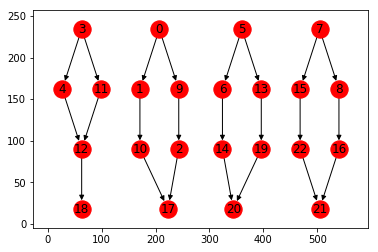

In [17]:
def draw_graph(G):
    pos = graphviz_layout(G, prog='dot')
    nx.draw_networkx(G, pos, with_labels=True, arrows=True)

draw_graph(G)

# write_dot(G, file_name+'.dot') # save in dot format (use xdot to plot the graph)
# plt.savefig('nx_test.pdf') # save in pdf format

# Kanellakis Smolka Algorithm for Computing Strong Bisimulation

In [22]:
# Kanellakis Smolka algorithm is used to compute strong bisimulation equivalence classes.
# For more info on strong bisimulation, please see: Section 7.1 of "Principles of model checking", Christel Baier and Joost-Pieter Katoen
# For more info on Kanellakis Smolka algorithm, please see: Section 7.3 of "Principles of model checking", Christel Baier and Joost-Pieter Katoen


def initial_partition(s1, s2):
    """
    return true if labels of s1 and s2 are equal
    """
    return node_labels[s1] == node_labels[s2]

def pre(G, C):
    """
    return a list of predecessors of nodes of C.
    nodes in a self-loop are not considered as a predecessor.
    """
    pre = set() # empty set
    for s in C: # C is a set of nodes
        for u in G.predecessors(s):
            if u != s:
                pre.add(u)
            
    return pre

def refine(Pi, C):
    """
    Refine each block B of Pi into B&pre(C) and B-pre(C).
    Pi is a list of sets
    """
    pre_C = pre(G, C)
    for B in Pi:
        inter = B & pre_C
        diff = B - pre_C
        if len(inter) != 0 and len(diff) != 0:
            Pi.remove(B)
            Pi.append(inter)
            Pi.append(diff)
    return Pi
        
def Kanellakis_Smolka(G):
    Q = nx.quotient_graph(G, partition=initial_partition)
    Pi_AP = [n for n in Q]
    Pi = Pi_AP
    Pi_old = []
    while Pi_old != Pi:
        Pi_old = Pi.copy()
        for C in Pi_old:
            refine(Pi, C)
    return Pi

Kanellakis_Smolka(G)


[frozenset({'22'}),
 frozenset({'11'}),
 frozenset({'9'}),
 frozenset({'15'}),
 frozenset({'19'}),
 frozenset({'17', '18', '20', '21'}),
 frozenset({'2'}),
 frozenset({'1', '4', '6', '8'}),
 frozenset({'3'}),
 frozenset({'0'}),
 frozenset({'7'}),
 frozenset({'5'}),
 frozenset({'13'}),
 frozenset({'10', '12', '14', '16'})]

# Groote Vaandrager Algorithm for Computing Weak (Stutter) Bisimulation

In [23]:
# Groote Vaandrager algorithm is used to compute weak (stutter) bisimulation equivalence classes.
# For more info on weak bisimulation and Groote Vaandrager algorithm, please see: Section 7.8 of "Principles of model checking", Christel Baier and Joost-Pieter Katoen


def pre_star(G, B, C):
    """
    Return states in B that have a simple path to a state in C.
    All nodes of the path belong to B, except the last node.
    B and C are sets of nodes and are disjoint
    """
    pre_s = set() # empty set
    for b in B:
        for c in C:
            if b not in pre_s:
                for p in nx.all_simple_paths(G, b, c):
                    if set(p[:-1]).issubset(B):
                        pre_s |= set(p[:-1])
            
    return pre_s

def is_in_stutter_cycle(G, source):
    """
    Check if node s is in a stutter cycle or not
    """
    if source not in G:
        return False
    post_source = [u for u in iter(G[source])]
    if post_source == [source]:
        return True
    visited = set()
    visited.add(source)
    stack = [source]
    while stack:
        s = stack.pop()
        post_s = [u for u in iter(G[s]) if u != s]
        for w in post_s:
            if node_labels[w] == node_labels[source]:
                if w == source:
                    return True
                elif w != s:
                    if w not in visited:
                        visited.add(w)
                        stack.append(w)        
    return False

def divergence_sensitive_expansion(G):
    G.add_node('div', data='div')
    node_labels['div'] = 'div'
    for s in G:
        if is_in_stutter_cycle(G, s):
            G.add_edge(s, 'div', probability='0.0001')
    G.add_edge('div', 'div', probability='1.0')
    
def Groote_Vaandrager(G):
    Q = nx.quotient_graph(G, partition=initial_partition)
    Pi_AP = [n for n in Q]
    Pi = Pi_AP
    Pi_old = []
    while Pi_old != Pi:
        Pi_old = Pi.copy()
        removed = False
        for C in Pi_old:
            for B in Pi_old:
                if B != C:
                    pre_s = pre_star(G, B, C)
                    inter = B & pre_s
                    diff = B - pre_s
                    if len(inter) != 0 and len(diff) != 0:
                        Pi.remove(B)
                        Pi.append(inter)
                        Pi.append(diff)
                        removed = True
                        break
            if removed:
                break
    return Pi
    
divergence_sensitive_expansion(G)
Groote_Vaandrager(G)

[frozenset({'div'}),
 frozenset({'22'}),
 frozenset({'17', '18', '19', '20', '21'}),
 frozenset({'2'}),
 frozenset({'15'}),
 frozenset({'10', '11', '12', '13', '14', '16'}),
 frozenset({'9'}),
 frozenset({'7'}),
 frozenset({'0'}),
 frozenset({'1', '3', '4', '5', '6', '8'})]